# NBA Shot Chart Scraper for Players Using Selenium in MS Edge Browser


In [2]:
#Install libraries
!pip install pandas selenium bs4 matplotlib

In [3]:
#import libraries
import pandas as pd
from selenium import webdriver
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

Enter the three-letter code for the opponent team (leave blank for all opponents): 
Enter 1st, 2nd, 3rd, or 4th (leave blank for all qurters): 4th
Enter Home or Away for Venue (leave blank for all games): Home
Please enter shot value of 2 or 3 (leave blank for all): 3
Enter minimum shot distance (leave blank for no minimum): 
Enter maximum shot distance (leave blank for no maximum): 


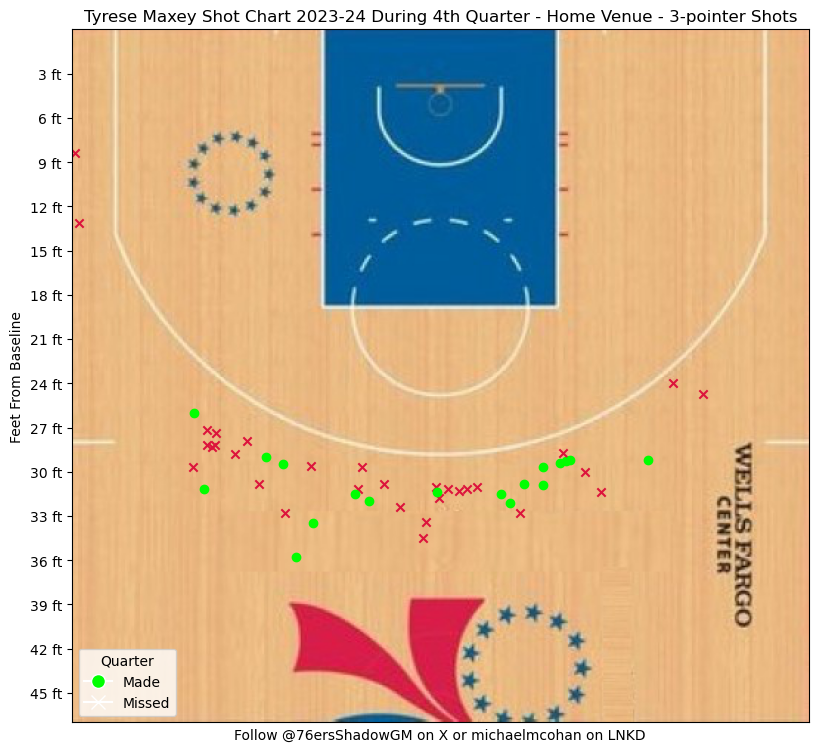

In [5]:
# Set Player name and season for chart title
player = 'Tyrese Maxey'
season = '2023-24'
# URL of the player's unfiltered shot chart for selected season (2023-24 is 2024 at end of url)
url = 'https://www.basketball-reference.com/players/m/maxeyty01/shooting/2024'

# Configure Selenium web driver for Microsoft Edge (make sure to have the appropriate driver executable in your system PATH)
# Attaching MS Edge Chromium Webdriver to repository See: 
# https://stackoverflow.com/questions/63529124/how-to-open-up-microsoft-edge-using-selenium-and-python
# For explanation
driver = webdriver.Edge()

# Load the webpage
driver.get(url)

# Extract the HTML content
html_content = driver.page_source

# Close the web driver
driver.quit()

# Parse the HTML content with BeautifulSoup
soup = BeautifulSoup(html_content, 'html.parser')

# Find the elements containing the shot chart data
shot_elements = soup.find_all('div', class_='tooltip')

# Initialize an empty list to store the shot chart data
shots_data = []

# Extract the shot chart data from the elements
for shot_element in shot_elements:
    style = shot_element.get('style')
    tip = shot_element.get('tip')
    
    # Extract the pixel coordinates from the style attribute
    style_parts = style.split(';')
    top = int(style_parts[0].replace('top:', '').replace('px', ''))
    left = int(style_parts[1].replace('left:', '').replace('px', ''))
    
    # Extract the additional information from the tip attribute
    tip_parts = tip.split('<br>')
    game = tip_parts[0]
    time = tip_parts[1]
    outcome = tip_parts[2]
    score = tip_parts[3]
    
    # Extract shot outcome (made or missed)
    result = outcome.split()[0]
    
    # Extract shot distance
    distance = outcome.split()[-2:]
    shot_distance = ' '.join(distance)
    
    shots_data.append({
        'FromBaseline': top,
        'FromLeft': left,
        'Game': game,
        'Time': time,
        'Outcome': outcome,
        'Shot Distance': shot_distance,
        'Score': score
    })

# Create a dataframe from the shot chart data
df = pd.DataFrame(shots_data)

# Extract Quarter
df['Quarter'] = df['Time'].str.split(' ').str[0]
df['Shot'] = df['Outcome'].str.split(' ').str[0]
df['Type'] = df['Outcome'].str.split(' ').str[1]
df['Distance'] = df['Shot Distance'].str.split(' ').str[0].astype(float)  # Convert 'Distance' to numeric

# Extract Clock
df['Clock'] = df['Time'].str.split(', ').str[1].str[:-10]
df['Opponent'] = df['Game'].str.split(', ').str[2].str[-3:]
df['Day'] = df['Game'].str.split(', ').str[0]
df['Year'] = df['Game'].str.split(', ').str[1]
df['Quarter'] = df['Time'].str.split(' ').str[0]
df['Shot'] = df['Outcome'].str.split(' ').str[0]
df['Type'] = df['Outcome'].str.split(' ').str[1]
df['Home'] = df['Game'].str.split(', ').str[2].str[:-3]
df['Date'] = df['Day']+', '+df['Year']
df['Venue'] = df['Home'].str.slice(4, 6)
df['Venue'] = df['Venue'].replace('at', 'Away')
df['Venue'] = df['Venue'].replace('vs', 'Home')
df['Points'] = df['Score'].str.split(' ').str[-1]
df['76ers Points After Shot'] = df['Points'].str.split('-').str[0]
df['Opponent Points After Shot'] = df['Points'].str.split('-').str[1]
df['MinsLeft'] = df['Clock'].str.split(':').str[0]
df['SecsLeft'] = df['Clock'].str.split(':').str[1]
df['ShotPoints'] = df['Type'].str.slice(0, 1)
df['ShotPoints']= df['ShotPoints'].astype(int)
df['76ers Points After Shot']= df['76ers Points After Shot'].astype(int)
df['Opponent Points After Shot']= df['Opponent Points After Shot'].astype(int)
df['SecsLeft'] = df['SecsLeft'].astype(int)
df['MinsLeft'] = df['MinsLeft'].astype(int)
df['Distance'] = df['Distance'].astype(int)
df['SecsLeft'] = df['SecsLeft']/60
df['Mins Left in Q'] = df['MinsLeft'] + df['SecsLeft']
for i in df['Shot']:
    if i == 'Missed':
        df['Margin'] = df['76ers Points After Shot'] - df['Opponent Points After Shot']
    else:
        df['Margin'] = df['76ers Points After Shot'] - df['ShotPoints'] - df['Opponent Points After Shot']
df = df.drop(columns=['Game','Time','Outcome','Day','Year','Home','Score','Points','MinsLeft','SecsLeft','76ers Points After Shot','Opponent Points After Shot','ShotPoints'])

# Invert Y coordinates
df['FromBaseline'] = 470 - df['FromBaseline']

# Convert pixel values to feet on the Y-axis
df['Feet From Baseline'] = 47 - (df['FromBaseline'] / 10)  # Scaling ratio: 10 pixels = 1 foot

# Get user input for opponent - This add parameters to filter the shot chart after scraping.  Input dialog boxes appear
opponent_code = input("Enter the three-letter code for the opponent team (leave blank for all opponents): ")

quarter_filter = input("Enter 1st, 2nd, 3rd, or 4th (leave blank for all qurters): ")

# Get user input for venue (optional)
venue_filter = input("Enter Home or Away for Venue (leave blank for all games): ")

# Get user input for type (optional)
type_filter = input("Please enter shot value of 2 or 3 (leave blank for all): ")

# Get user input for minimum shot distance (optional)
min_distance = input("Enter minimum shot distance (leave blank for no minimum): ")
min_distance = float(min_distance) if min_distance else None

# Get user input for maximum shot distance (optional)
max_distance = input("Enter maximum shot distance (leave blank for no maximum): ")
max_distance = float(max_distance) if max_distance else None

# Filter DataFrame based on user input
if opponent_code:
    df = df[df['Opponent'] == opponent_code]
    
if quarter_filter:
    df = df[df['Quarter'] == quarter_filter]

if venue_filter:
    df = df[df['Venue'] == venue_filter]

if type_filter:
    df = df[df['Type'] == f'{type_filter}-pointer']

if min_distance is not None:
    df = df[df['Distance'] >= min_distance]

if max_distance is not None:
    df = df[df['Distance'] <= max_distance]

# Set title based on the filters entered by the user
chart_title = f'{player} Shot Chart {season}'

if opponent_code:
    chart_title += f' Versus {opponent_code}'
    
if quarter_filter:
    chart_title += f' During {quarter_filter} Quarter'

if venue_filter:
    chart_title += f' - {venue_filter} Venue'

if type_filter:
    chart_title += f' - {type_filter}-pointer Shots'

if min_distance is not None and max_distance is not None:
    chart_title += f' - Distance: {min_distance}-{max_distance}'
elif min_distance is not None:
    chart_title += f' - Distance: {min_distance} and above'
elif max_distance is not None:
    chart_title += f' - Distance: {max_distance} and below'

# Upload the image and plot the x, y coordinates
fig, ax = plt.subplots(figsize=(10, 9))

# Load the image
img_path = 'half76.jpg'  # Replace with the actual path to your image file
img = plt.imread(img_path)

# Plot the image
ax.imshow(img, extent=[0, 500, 0, 470])

# ... (rest of the code remains unchanged)

# Plot the x, y coordinates
for i, row in df.iterrows():
    x = row['FromLeft']
    y = row['FromBaseline']

    # Determine marker color based on 'Shot' and 'Quarter'
    marker_color = {'1st': 'dodgerblue', '2nd': 'crimson', '3rd': 'lime', '4th': 'fuchsia'}.get(row['Quarter'], 'black')

    # Add a marker for each point
    if quarter_filter:  # Check if quarter filter is applied
        marker_shape = 'x' if row['Shot'] == 'Missed' else 'o'
        marker_color = 'lime' if row['Shot'] == 'Made' else 'crimson'
    else:
        marker_shape = 'x' if row['Shot'] == 'Missed' else 'o'

    ax.scatter(x, y, color=marker_color, marker=marker_shape)
    
        # Add additional information as annotation (optional)
    #annotation_text = f"Clock: {row['Clock']}\nMargin: {row['Margin']}"
    #ax.annotate(annotation_text, (x, y), textcoords="offset points", xytext=(0,8), ha='left', fontsize=5, color='black')

# Set axis labels and title
ax.set_xlabel('Follow @76ersShadowGM on X or michaelmcohan on LNKD')
ax.set_ylabel('Feet From Baseline')  # Updated Y-axis label
ax.set_title(chart_title)

if quarter_filter:
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lime', markersize=10, label='Made'),
        plt.Line2D([0], [0], marker='x', color='w', markerfacecolor='crimson', markersize=10, label='Missed')
    ]
else:
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='dodgerblue', markersize=10, label='1st Quarter'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lime', markersize=10, label='2nd Quarter'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='crimson', markersize=10, label='3rd Quarter'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='fuchsia', markersize=10, label='4th Quarter'),
    ]

ax.legend(handles=legend_handles, title='Quarter', loc='lower left')

# Add Y-axis hashmarks and labels
hashmarks_y = [440, 410, 380, 350, 320, 290, 260, 230, 200, 170, 140, 110, 80, 50, 20]  # Updated hashmark positions
hashmark_labels = ['3 ft', '6 ft', '9 ft', '12 ft', '15 ft', '18 ft', '21 ft', '24 ft', '27 ft', '30 ft', '33 ft', '36 ft', '39 ft', '42 ft', '45 ft']
ax.set_yticks(hashmarks_y)
ax.set_yticklabels(hashmark_labels)

# Hide X-axis hashmarks and labels
ax.set_xticks([])

# Show the plot
plt.show()
